<h1>Handwriting recognition</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

<h2>Data import and visualization</h2>
Import the MNIST train dataset (https://en.wikipedia.org/wiki/MNIST_database).

In [2]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data = np.genfromtxt("mnist_train_small.csv", delimiter=",")
data.shape

(20000, 785)

Store the data in a matrix and the labels in a vector. <br>
REMARK: In this lab we will work with features/classes on rows and samples on columns.

In [3]:
labels = data[:, 0]
x_data = data[:, 1:].transpose() / 255
labels.shape, x_data.shape

((20000,), (784, 20000))

Visualize the first 30 pictures with the corresponding labels.

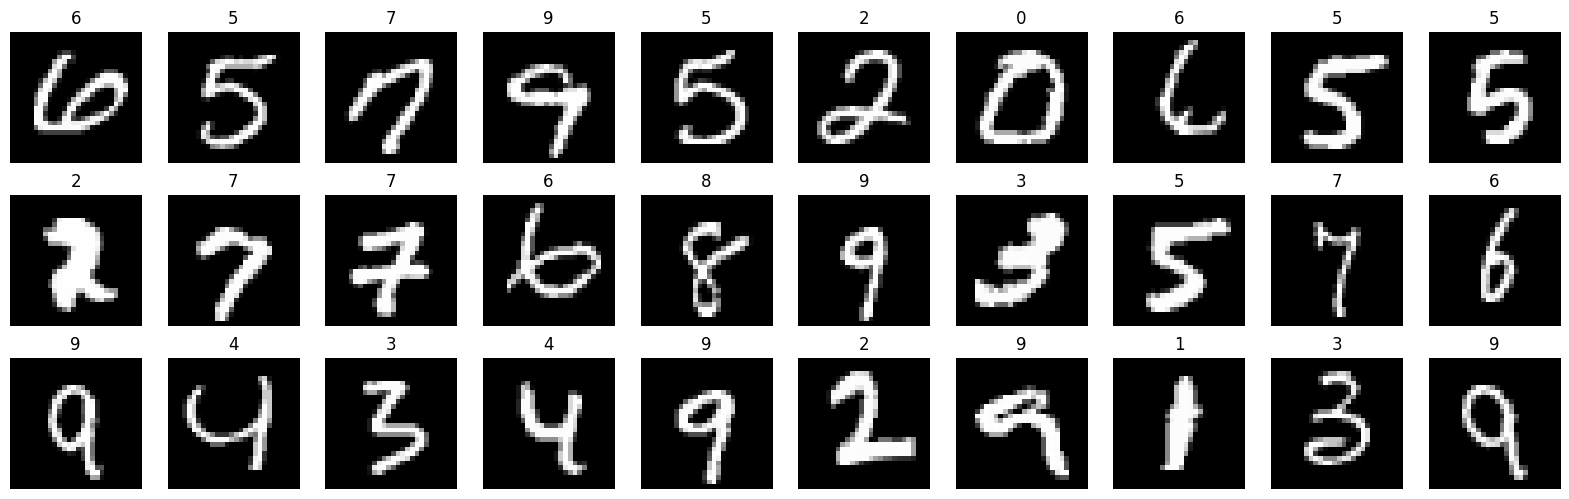

In [4]:
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 6))
axs = axs.reshape((-1,))
for i in range(30):
    image_i = x_data[:, i].reshape((28, 28))
    axs[i].imshow(image_i, cmap="gray")
    axs[i].set_title(int(labels[i]))
    axs[i].axis("off")

Create a one-hot representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit). The entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise.

In [5]:
y_data = np.zeros((10, 20000))
for i in range(10):
    y_data[i, labels == i] = 1

Check that the matrix has exactly one element "1" in each column.

In [6]:
row_sums = np.sum(y_data, axis=0)
row_sums.min(), row_sums.max()

(np.float64(1.0), np.float64(1.0))

<h2>ANN training</h2>

Write a function to initialize the parameters (with Glorot Normal initialization) and a function implementing a feedforward ANN with tanh activation function. <br>
To the last layer of the ANN, apply a soft-max layer. If $z_1, ..., z_n$ are the activation of the last layer neurons, the soft-max layer produces $\hat{z_i},..., \hat{z_n}$ defined as
$$
\hat{z_i} = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$
In this manner the outputs of the ANN satisfy by construction:
- $\hat{z_i} \in [0,1]$
- $\sum_{j=1}^n \hat{z_j} = 1$
Therefore, they can be interpreted as probabilities. <br>
When the ANN will nbe trained, we will take the digit corresponding the highest probability as prediction of the model.

In [7]:
def initialize_params(layers_size):
    np.random.seed(0)
    params = []
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i]) * np.sqrt(
            1 / (layers_size[i] + layers_size[i + 1])
        )
        b = np.zeros((layers_size[i + 1], 1))
        params.append(W)
        params.append(b)
    return params

def ANN(x, params):
    # NOTE: we are working with features/classes on rows and samples on columns
    # Thus, should we transpose x, like in the previous lab?
    layer = x
    num_layers = len(params) // 2 + 1
    weights = params[::2]
    biases = params[1::2]

    for i in range(num_layers - 1):
        layer = np.dot(weights[i], layer) + biases[i]
        if i < num_layers - 2:
            layer = jnp.tanh(layer)

    return jax.nn.softmax(layer, axis=0)

    # NOTE: for the softmax we use the jax function, do not implement it from scratch
    # Working with exponentials is dangerous, overflow may occur, rely on robust implementations

Test the ANN and check that the above properties are satisfied.

In [8]:
# check the minumum and the maximum of the prediction for 'x_data' if between 0 and 1
# check that the sum of the outputs (for each input) is 1
param = initialize_params([784, 20, 10])
y_pred = ANN(x_data, param)
y_pred_sum = jnp.sum(y_pred, axis=0)
jnp.min(y_pred_sum), jnp.max(y_pred_sum)
jnp.min(y_pred), jnp.max(y_pred)

(Array(0.0309209, dtype=float32), Array(0.20696934, dtype=float32))

Implement the following metrics:
- mean square error
- cross entropy
- accuracy (fraction of sasmples correctly classified)

In [9]:
def MSE(x, y, params):
    y_pred = ANN(x, params)
    error = y - y_pred
    return jnp.mean(error * error)

def cross_entropy(x, y, params):
    y_pred = ANN(x, params)
    return -jnp.mean(jnp.sum(jnp.log(y_pred) * y, axis=0))

def accuracy(x, y, params):
    y_pred = ANN(x, params)
    labels_predicted = jnp.argmax(y_pred, axis=0)
    labels = jnp.argmax(y, axis=0)
    return jnp.mean(labels_predicted == labels)

print("MSE: %f" % MSE(x_data, y_data, param))
print("X entropy: %f" % cross_entropy(x_data, y_data, param))
print("Accuracy: %f" % accuracy(x_data, y_data, param))

MSE: 0.090217
X entropy: 2.314617
Accuracy: 0.111000


Put 10000 images in the training set and 10000 images in the validation set.

In [10]:
idxs = np.random.permutation(20000)
x_data = x_data[:, idxs]
y_data = y_data[:, idxs]

x_train = x_data[:, :10000]
y_train = y_data[:, :10000]
x_valid = x_data[:, 10000:]
y_valid = y_data[:, 10000:]

Run this cell. We will use it later.

In [11]:
from IPython import display

class Callback:
    def __init__(self, refresh_rate=250):
        self.refresh_rate = refresh_rate
        self.fig, self.axs = plt.subplots(1, figsize=(16,8))
        self.epoch = 0
        self.__call__(-1)

    def __call__(self, epoch):
        self.epoch = epoch
        if (epoch + 1) % self.refresh_rate == 0:
            self.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-16)

    def draw(self):
        if self.epoch > 0:
            self.axs.clear()
            epochs = np.arange(1, len(history_train_Xen) + 1)
            self.axs.loglog(epochs, history_train_Xen, "b-", label="train_Xen")
            self.axs.loglog(epochs, history_valid_Xen, "r-", label="valid_Xen")
            self.axs.loglog(epochs, history_valid_MSE, "b--", label="valid_MSE")
            self.axs.loglog(epochs, history_valid_acc, "r--", label="valid_acc")

            self.axs.legend()
            self.axs.set_title(
                "epoch %d - accuracy %0.1f%%" 
                % (self.epoch + 1, 100 * history_valid_acc[-1])
            )

Train an ANN-based classifier with two hidden layers with 50 neurons each. Use 500 epochs of the RMSProp algorithm, with decay rate 0.9 and $\delta=10^{-7}$ and fixed learning rate $\lambda=0.002$. Use minibatches with batch size of 1000. <br>
Use the cross-entropy loss to drive the training. To monitor training, store every 10 training epochs the following metrics in the following lists:
- history_train_Xen: cross-entropy (training set)
- history_valid_Xen: cross-entropy (validation set)
- history_valid_MSE: MSE (validation set)
- history_valid_acc: accuracy (validation set)

In [ ]:
# Hyperparameters
layers_size = [784, 50, 50, 10]
# Training options
num_epochs = 500
batch_size = 1000
learning_rate = 2e-3
decay_rate = 0.9
delta = 1e-7

############################################
# Initialize params and its objects

params = initialize_params(layers_size)

grad = jax.grad(cross_entropy, argnums=2)
grad_jit = jax.jit(grad)

cross_entropy_jit = jax.jit(cross_entropy)
MSE_jit = jax.jit(MSE)
accuracy_jit = jax.jit(accuracy)

############################################

history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()

def dump():
    history_train_Xen.append(cross_entropy_jit(x_train, y_train, params))
    history_valid_Xen.append(cross_entropy_jit(x_valid, y_valid, params))
    history_valid_MSE.append(MSE_jit(x_valid, y_valid, params))
    history_valid_acc.append(accuracy_jit(x_valid, y_valid, params))

dump()
cb = Callback(refresh_rate=50)

n_train = 10000

cumulated_sqr_grad = [0.0 for _ in range(len(params))]
for epoch in range(num_epochs):
    idxs = np.random.choice(n_train, batch_size)
    grad_val = grad(x_train[:, idxs], y_train[:, idxs], params)

    for i in range(len(params)):
        cumulated_sqr_grad[i] = (
            decay_rate * cumulated_sqr_grad[i] + 
            (1 - decay_rate) * grad_val[i] * grad_val[i]
        )
        params[i] -= grad_val[i] * learning_rate / (delta + jnp.sqrt(cumulated_sqr_grad[i]))
    
    dump()
    cb(epoch)
cb.draw()


<h2>Testing</h2>
Load the dataset mnist_test.csv and compute the accuracy of the classifier on this dataset.

In [15]:
data_test = np.genfromtxt("mnist_train_small.csv", delimiter=",")
data_test.shape
labels_test = data_test[:, 0]
x_test = data_test[:, 1:].transpose() / 255
y_test = np.zeros((10, x_test.shape[1]))
for i in range(10):
    y_test[i, labels_test == i] = 1
x_test.shape, y_test.shape

((784, 20000), (10, 20000))

In [ ]:
test_acccuracy = accuracy_jit(x_test, y_test, params)
test_MSE = MSE_jit(x_test, y_test, params)
test_crossent = cross_entropy_jit(x_test, y_test, params)

print(f"Test accuracy: {test_acccuracy * 100:.2f}%")
print(f"Test MSE: {test_MSE:.4e}%")
print(f"Test cross entropy: {test_crossent:.4e}%")

Use the following script to visualize the predictions on a bunch of test images.

In [ ]:
offset = 0
n_images = 40

images_per_row = 10
y_predicted = ANN(x_test[:, offset : offset + n_images], params)

def draw_bars(ax, y_predicted, label):
    myplot = ax.bar(range(10), (y_predicted))
    ax.set_ylim([0, 1])
    ax.set_xticks(range(10))

    label_predicted = np.argmax(y_predicted)
    if label == label_predicted:
        color = "green"
    else: 
        color = "red"
    myplot[label_predicted].set_color(color)

import math

n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize=(3 * images_per_row, 3 * n_rows))
row = 0
col = 0
for i in range(n_images):
    axs[2 * row, col].imshow(x_test[:, offset + i].reshape((28, 28)), cmap="gray")
    axs[2 * row, col].set_title(int(labels_test[offset + i]))
    axs[2 * row, col].axis("off")

    draw_bars(axs[2 * row + 1, col], y_predicted[:, i], int(labels_test[offset + i]))

    col += 1
    if col == images_per_row:
        col = 0
        row += 1

<h2>Adversarial attacks</h2>
You have trained your classifier. Cool, isn't it? Let us now try to fool it. <br>
Consider the last image of the training set. Visualize it and visualize the associated predictions of the classifier.

In [ ]:
x = x_data[:, -1][:, None]
y = y_data[:, -1][:, None]
label = np.argmax(y)

_, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(x.reshape((28, 28)), cmap="gray")
axs[0].axis("off")

y_pred = ANN(x, params)

draw_bars(axs[1], y_pred[:, 0], label)

An adversarial attack consists of an (almost imperceptible) modification of the image, aimed at fooling the classifier into making a mistake. <br>
To hack the classifier, compute the gradient of cross entropy loss function with respect to the imput (not to the parameters!). Then, superimpose a multiple of the gradient to the original image. <br>
Visualize the original and the hacked images and the corresponding prediction of the classifier.

In [ ]:
grad_fn = jax.grad(cross_entropy, argnums=0)
grad_val = grad_fn(x, y, params)
x_updated = x + 1.0 * grad_val
y_updated = ANN

_, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(x.reshape((28, 28)), cmap="gray")
axs[0].set_title("original picture")
draw_bars(axs[1], y_pred[:, 0], label)
axs[2].imshow(grad_val.reshape((28, 28)), cmap="gray")
axs[2].set_title("gradient")
axs[3].imshow(x_updated.reshape((28, 28)), cmap="gray")
axs[3].set_title("hacked picture")
draw_bars(axs[4], y_updated[:, 0], label)